# Image Classification PyTorch 03

Dataset: https://www.kaggle.com/datasets/tongpython/cat-and-dog

The data is balance:
- Train 4000 cats and 4000 dogs
- Test 1000 cats and 1000 dogs

Using 2 Conv2d and 2 Linear, add Dropout

Import function

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
TRAIN_FOLDER = '~/data1/data/mlzoomcamp25/catdog/train'
TEST_FOLDER = '~/data1/data/mlzoomcamp25/catdog/test'

SEED = 42
BATCH_SIZE = 20
IMAGE_SIZE = 150
EPOCHS = 15

In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [6]:
train_dataset = datasets.ImageFolder(TRAIN_FOLDER, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_FOLDER,  transform=test_val_transform)

# verify the number of classes
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


Classes: ['cats', 'dogs']


In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                          )

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                         )


In [8]:
# create model
class CatDogModel(nn.Module):
    def __init__(self):
        super(CatDogModel, self).__init__()

        # Hout​=(Input+2Padding−Kernel​)/Stride+1
        self.base_model = nn.Sequential(
            # (150 + 2*0 - 3)/1 + 1 = 148
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0), # (32, 148, 148)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (32, 74, 74)
            # (74 + 2*0 - 3)/1 + 1 = 72
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0), # (64, 72, 72)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (64, 36, 36)
        )
        self.flatten = nn.Flatten() # (64, 36*36,) = 82944
        self.fc = nn.Sequential(
            nn.Linear(64 * 36 * 36, 1024), # (1024,)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1), # (1,)
        )
               

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x 

In [9]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        labels = labels.float()
        if labels.ndim == 1:
            labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights

        total_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [10]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels.float()
            if labels.ndim == 1:
                labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [11]:

model = CatDogModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-4)

Training loop

In [12]:

arr_train_acc = []
arr_train_loss = []

arr_test_acc = []
arr_test_loss = []

idx = 0
for epoch in range(EPOCHS):

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = validate(model, test_loader, criterion)

    arr_train_acc.append(train_acc)
    arr_train_loss.append(train_loss)
    arr_test_acc.append(test_acc)
    arr_test_loss.append(test_loss)

    print(idx)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {test_loss:.4f} | Val Acc: {test_acc:.4f}")

    idx += 1


0
Epoch 1/15
  Train Loss: 0.6922 | Train Acc: 0.5238
  Val Loss  : 0.6908 | Val Acc: 0.5388
1
Epoch 2/15
  Train Loss: 0.6883 | Train Acc: 0.5660
  Val Loss  : 0.6878 | Val Acc: 0.5665
2
Epoch 3/15
  Train Loss: 0.6855 | Train Acc: 0.5794
  Val Loss  : 0.6852 | Val Acc: 0.5749
3
Epoch 4/15
  Train Loss: 0.6828 | Train Acc: 0.5900
  Val Loss  : 0.6827 | Val Acc: 0.5793
4
Epoch 5/15
  Train Loss: 0.6798 | Train Acc: 0.6017
  Val Loss  : 0.6805 | Val Acc: 0.5843
5
Epoch 6/15
  Train Loss: 0.6774 | Train Acc: 0.6006
  Val Loss  : 0.6781 | Val Acc: 0.5952
6
Epoch 7/15
  Train Loss: 0.6751 | Train Acc: 0.6122
  Val Loss  : 0.6759 | Val Acc: 0.5966
7
Epoch 8/15
  Train Loss: 0.6723 | Train Acc: 0.6152
  Val Loss  : 0.6737 | Val Acc: 0.6080
8
Epoch 9/15
  Train Loss: 0.6706 | Train Acc: 0.6162
  Val Loss  : 0.6719 | Val Acc: 0.5981
9
Epoch 10/15
  Train Loss: 0.6682 | Train Acc: 0.6187
  Val Loss  : 0.6697 | Val Acc: 0.6204
10
Epoch 11/15
  Train Loss: 0.6655 | Train Acc: 0.6239
  Val Loss  :

Plot the result

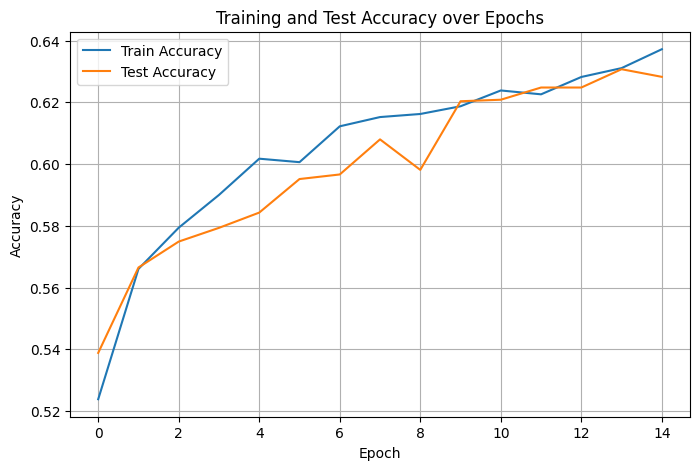

In [13]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_acc, label='Train Accuracy')
plt.plot(arr_test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

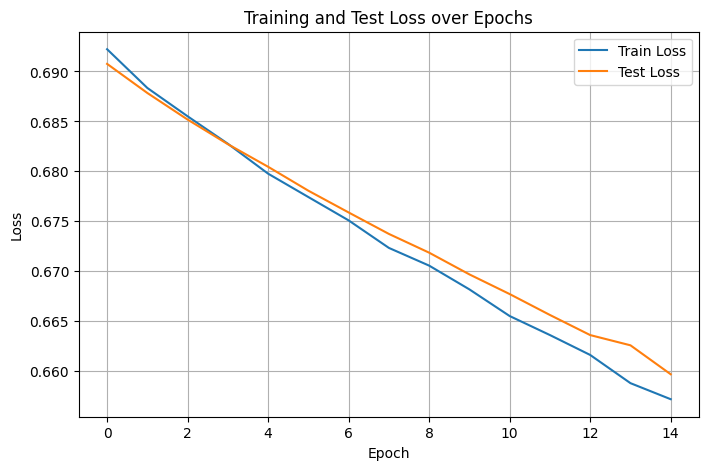

In [14]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_loss, label='Train Loss')
plt.plot(arr_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:

df_train = pd.DataFrame({
    'train_loss': arr_train_loss,
    'train_accuracy': arr_train_acc
})
df_train

,train_loss,train_accuracy
0,0.692223,0.523798
1,0.688347,0.566021
2,0.685512,0.579388
3,0.682764,0.590006
4,0.679770,0.601749
5,0.677432,0.600625
6,0.675096,0.612242
7,0.672343,0.615240
8,0.670571,0.616240
9,0.668192,0.618738
